# NBA Crime Library: Building a dataset + exploratory analysis (Scripting Languages project)

## Goal
In this project, I build a structured dataset by combining two sources: (1 a web-scraped dataset from the NBA Crime Library and (2 an external player database used for further analysis

**Dataset 1: NBA Crime Library (scraped dataset)**
The NBA Crime Library is a curated website that documents arrests involving NBA players. The site is organized as one webpage per player, but a single player page can contain multiple arrest events (for example: different arrest dates, different charges, or separate incidents across years).

To reflect this structure correctly, I convert the website into a tabular dataset where each row represents one arrest record, rather than one player. This avoids collapsing multiple incidents into a single row and makes it possible to study time trends and repeat offenders. For each arrest record, I extract the main fields provided on the page, such as:


*   Player name

*   Arrest date

*   Charge(s)

*   Crime category (based on the “Reason for arrest” category tags on the website)
*   Additional data when available (e.g franchise, age, narrative “Details”, and the original post URL)

**Dataset 2: Kaggle NBA Player Database (augmentation dataset)**
To go beyond the information available on the NBA Crime Library site, I augment the scraped arrest records with an external dataset: the Kaggle “NBA Players Database” (PlayerIndex_nba_stats.csv). This dataset contains player-level attributes and summary statistics, including:
*   Player profile information (position, height, weight, college, country)


*   Draft information (draft year/round/number)


*   Basic performance indicators (PTS/REB/AST)


*   Team-related fields (team city, team ID, roster status)

Because the two datasets do not share a common unique identifier, I link them using player names (after cleaning and normalizing names to maximize matching accuracy). After matching, each arrest record can optionally include these additional player variables, enabling exploratory comparisons such as whether certain crime categories are more common among particular position groups, draft tiers, or performance profiles.

## Research questions
1. Crime types: Which crime categories occur most frequently in the NBA Crime Library dataset?
2. Augmentation: Can these arrest records be enriched with basic player information (e.g., position, height/weight, draft data, and summary performance stats), and do any descriptive patterns emerge when comparing crime categories across player “profiles”?


## Notes / limitations
- NBA Crime Library is a curated website (not an official court database). Findings are descriptive for this dataset.
- Some fields (e.g., “Details”) are missing for a subset of records because the site does not always provide them.
- Gen AI has been used to improve the clarity/language quality of the markdown texts


## Website structure (what I scrape)

NBA Crime Library is built as a WordPress blog. Each incident is described on a post page that contains semi-structured fields such as:

- Charge
- Arrest Date
- Franchise
- Age
- Details (free-text narrative)

Below is an example post page (this is the structure my scraper is designed to parse):

 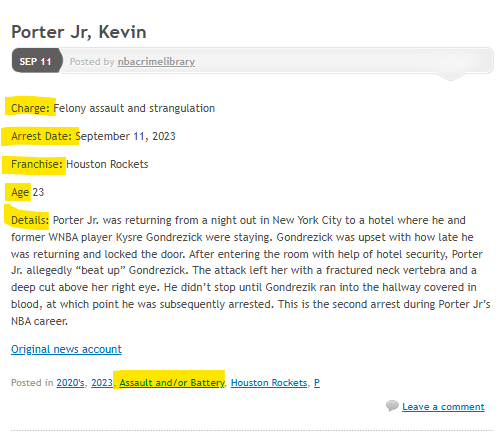

In addition, posts include category tags at the bottom. I use the tags under the “Reason for arrest” category hierarchy as the official crime category for each record.


In [10]:
# regular expressions: pattern matching in strings (e.g., extract years, clean names)
import re
# to use for polite scraping = sleep()
import time

# make HTTP requests to download HTML pages
import requests

# For tabular data (DataFrame) for cleaning+EDA
import pandas as pd

# parse HTML into a tree you can query
from bs4 import BeautifulSoup

# safely combine a base URL with a path
from urllib.parse import urljoin


# base URL of the website of the scraped URL
BASE = "https://nbacrimelibrary.com/"

# HTTP header so the site treats us like a normal browser
HEADERS = {"User-Agent": "Mozilla/5.0"}

# waiting time (seconds) between requests to reduce server load --> Scrqping politely
SLEEP = 0.8  # be polite


"""
AI SUGGESTION:
  Normalize whitespace in a string.
  Example: "  Hello   world \n" -> "Hello world"
  Why: HTML text often contains extra whitespace, newlines, tabs.
"""
def norm_ws(s: str) -> str:
    return " ".join(str(s).split()).strip()


"""
AI SUGGESTION:
    Remove duplicates from a sequence while preserving original order.
    Why: when scraping pages, the same URL can appear multiple times.

"""


"""
Download the HTML at a URL and return a BeautifulSoup parser object.

Steps:
1) requests.get(...) downloads the page

2) raise_for_status() throws an error if HTTP status is 4xx/5xx

3) BeautifulSoup parses HTML into a searchable structure
"""
def dedupe_keep_order(seq):
    seen = set()
    out = []
    for x in seq:
        if x not in seen:
            seen.add(x)
            out.append(x)
    return out

def soup_from(url: str) -> BeautifulSoup:
    r = requests.get(url, headers=HEADERS, timeout=30)
    r.raise_for_status()
    return BeautifulSoup(r.text, "html.parser")


## 1. Data collection (web scraping)

Approach:
1. Scrape the official list of "Reason for arrest" categories from `crime-2/` to build a **master list**.
2. Discover which "Year of arrest" pages exist from `year/`.
3. For each year page, collect post URLs (handling pagination).
4. For each post URL, extract one or more **arrest records**:
   - Player Name
   - Arrest Date
   - Charge
   - Crime Category (mapped via category slug)
   - Franchise, Age, Details (when available)
5. Save results as a CSV.


## Extracting the player name (post title)

Each NBA Crime Library incident is stored as a WordPress post, and the player’s name appears as the **post title**.

However, depending on the WordPress theme, the title can be stored in different parts of the HTML:
- as an OpenGraph meta tag (`og:title`)
- as an `<h1>` element in the post header
- inside the `<title>` tag in the page `<head>`

To make the scraper robust, I try multiple strategies in a fixed order and return the first valid title that is found.

Finally, the website often formats names as **“Last, First”** (e.g., “Beard, Ralph”). For readability and for later merging with an external player database, I convert this to **“First Last”**.


In [11]:
def get_player_name(soup: BeautifulSoup):
    """
    Extract the player's name (post title) from a post page using multiple strategies.
    """

    # 1) OpenGraph title: often the cleanest source
    m = soup.find("meta", property="og:title")
    if m and m.get("content"):
        t = norm_ws(m["content"])

        # remove site suffix like " - NBA Crime Library"
        t = re.sub(r"\s*[-|]\s*NBA Crime Library\s*$", "", t, flags=re.I).strip()
        if t and t.lower() != "nba crime library":
            return t

    # 2) Common WordPress title selectors (suggested by AI)
    selectors = [
        "article h1.entry-title",
        "header.entry-header h1",
        "h1.entry-title",
        "h1.post-title",
        "article h1",
    ]
    for sel in selectors:
        tag = soup.select_one(sel)
        if tag:
            t = norm_ws(tag.get_text(" ", strip=True))
            if t and t.lower() != "nba crime library":
                return t

    # 3) Fallback: HTML <title> element
    if soup.title and soup.title.string:
        t = norm_ws(soup.title.string)
        t = re.sub(r"\s*[-|]\s*NBA Crime Library\s*$", "", t, flags=re.I).strip()
        if t and t.lower() != "nba crime library":
            return t

    return None


#Convert "Last, First" -> "First Last". If there is no comma, return unchanged. ("Porter Jr, Kevin" -> "Kevin Porter Jr")
def format_player_name(name: str):

    if not name:
        return name
    name = norm_ws(name)
    if "," in name:
        last, first = [p.strip() for p in name.split(",", 1)]
        if first and last:
            return f"{first} {last}"
    return name


## Building a master list of crime categories

NBA Crime Library assigns posts to official “Reason for arrest” categories (e.g., *Assault and/or Battery*, *Drugs - Marijuana offering*). These categories are listed on the website’s “Crime” page:

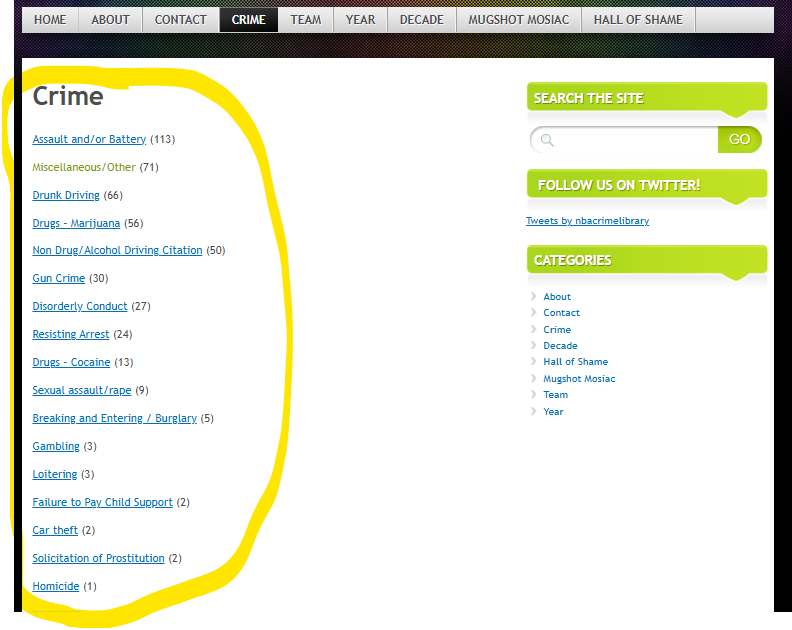

I scrape this page to build a **master list** of crime categories. Importantly, I store categories using the **URL slug** (the part at the end of the link), because the visible label text may vary slightly across pages (punctuation, dashes, capitalization). The slug is stable and allows reliable matching.

The result is a dictionary of the form:
- key: category slug (e.g., `drugs-marijuana`)
- value: cleaned category name (e.g., `Drugs - Marijuana`)


In [12]:
def build_master_crime_slug_map():
    """
    Scrape https://nbacrimelibrary.com/crime-2/ and build:
    { slug -> canonical crime label }

    Example:
      "drugs-marijuana" -> "Drugs - Marijuana"
    """
    url = urljoin(BASE, "crime-2/")
    soup = soup_from(url)

    #main content area (fallback to whole page if selector not found)
    content = soup.select_one("#content") or soup

    master = {}

    #links to reason-for-arrest categories contain this path segment
    for a in content.select('a[href*="/category/5-reason-for-arrest/"]'):
        href = a.get("href", "")
        txt = norm_ws(a.get_text(" ", strip=True))
        if not href or not txt:
            continue


        # remove counts like "Assault (113) (see picture above in text)" -> "Assault"
        name = txt.split(" (", 1)[0].strip()  # remove counts
        if not name:
            continue
        # extract the slug from the URL:
        # .../category/5-reason-for-arrest/<slug>/
        m = re.search(r"/category/5-reason-for-arrest/([^/]+)/?", href)
        if m:
            slug = m.group(1)
            if slug:
                master[slug] = name

    return master

master_crimes_by_slug = build_master_crime_slug_map()

print("Master crimes loaded:", len(master_crimes_by_slug))

#Check so it works
print("Sample:", list(master_crimes_by_slug.items())[:8])


Master crimes loaded: 17
Sample: [('assault-andor-battery', 'Assault and/or Battery'), ('miscellaneous', 'Miscellaneous/Other'), ('drunk-driving', 'Drunk Driving'), ('drugs-marijuana', 'Drugs – Marijuana'), ('non-drugalcohol-driving-citation', 'Non Drug/Alcohol Driving Citation'), ('gun-crime', 'Gun Crime'), ('disorderly-conduct', 'Disorderly Conduct'), ('resisting-arrest', 'Resisting Arrest')]


## Discovering which years exist on the site

NBA Crime Library organizes posts into “Year of arrest” category pages (e.g., 1951, 1972, 2003). However, not every year has posts.

To avoid guessing year ranges, I scrape the website’s year index page:

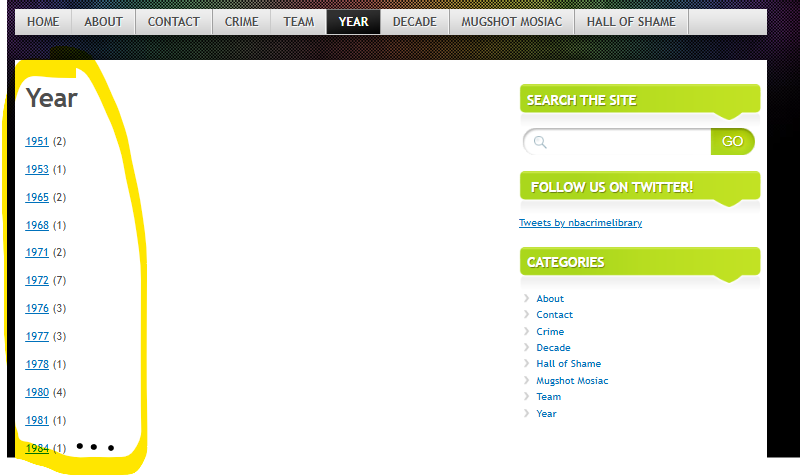

From this page I collect all URLs that match the pattern:
`/category/2-year-of-arrest/<YEAR>/`

This gives me the list of year pages that I should scrape.


In [13]:

#Scrape the year index page and collect all "Year of arrest' category URLs.
def get_year_category_urls():

    url = urljoin(BASE, "year/")
    soup = soup_from(url)

    year_urls = []
    for a in soup.find_all("a", href=True):
        href = a["href"]
        if "/category/2-year-of-arrest/" in href:

          # only keep URLs that actually contain a 4-digit year (AI SUGGESTION)
            m = re.search(r"/category/2-year-of-arrest/(\d{4})/?", href)
            if m:
                year_urls.append(href)

    return dedupe_keep_order(year_urls)

year_urls = get_year_category_urls()
print("Year category pages found:", len(year_urls))
print("First 10:", year_urls[:10])


Year category pages found: 51
First 10: ['https://nbacrimelibrary.com/category/2-year-of-arrest/1951/', 'https://nbacrimelibrary.com/category/2-year-of-arrest/1953/', 'https://nbacrimelibrary.com/category/2-year-of-arrest/1965/', 'https://nbacrimelibrary.com/category/2-year-of-arrest/1968/', 'https://nbacrimelibrary.com/category/2-year-of-arrest/1971/', 'https://nbacrimelibrary.com/category/2-year-of-arrest/1972/', 'https://nbacrimelibrary.com/category/2-year-of-arrest/1976/', 'https://nbacrimelibrary.com/category/2-year-of-arrest/1977/', 'https://nbacrimelibrary.com/category/2-year-of-arrest/1978/', 'https://nbacrimelibrary.com/category/2-year-of-arrest/1980/']


## Collecting post URLs from a year page (with pagination)

Each “Year of arrest” category page lists multiple posts (player incidents). To build the dataset, I first need to collect the **URLs of all posts** listed on each year page.

These category pages can be paginated. Therefore, the function below:
1. Downloads the year page
2. Extracts all post URLs (WordPress uses links with `rel="bookmark"`)
3. Follows the “next page” link until there are no more pages
4. Returns a de-duplicated list of post URLs

This part was struggle-some and required quite a bit of AI-help (Gemini)

In [14]:

#Collect all post URLs from a WordPress category page (like a year page), following pagination until exhausted. Returns a list of unique post URLs.
def get_posts_from_category(category_url, max_pages=200):
    posts = []
    next_url = category_url
    page = 0

    while next_url and page < max_pages:
        page += 1
        soup = soup_from(next_url)


        # In WordPress, each post title is usually a link with rel="bookmark"
        for a in soup.find_all("a", rel="bookmark", href=True):
            posts.append(a["href"])

        #Try several common ways wordpress encodes the "next" page link
        next_link = None

        #<link rel="next" href="...">
        tag = soup.find("link", rel="next", href=True)
        if tag:
            next_link = tag["href"]

        #<a class="next page-numbers" href="...">
        if not next_link:
            a = soup.select_one("a.next.page-numbers[href]")
            if a:
                next_link = a["href"]

        #<a rel="next" href="...">
        if not next_link:
            a = soup.find("a", rel="next", href=True)
            if a:
                next_link = a["href"]


        # For clean and polite delay between requests
        next_url = next_link
        time.sleep(SLEEP)

    return dedupe_keep_order(posts)


## Parsing a post into structured arrest record(s)

Each player incident page contains semi-structured fields such as:

- **Charge:** ...
- **Arrest Date:** ...
- **Franchise:** ...
- **Age:** ...
- **Details:** ...

Some posts contain **multiple arrest records** for the same player (multiple `Charge:` blocks).  
To avoid mixing information from different arrests, the parser returns a **list of records**, where each record corresponds to one `Charge:` section and the fields that follow it.

Same here as previously, this turned out to be quite complex and AI was needed.

Below is an example post structure (this is the pattern the parser is designed to read):

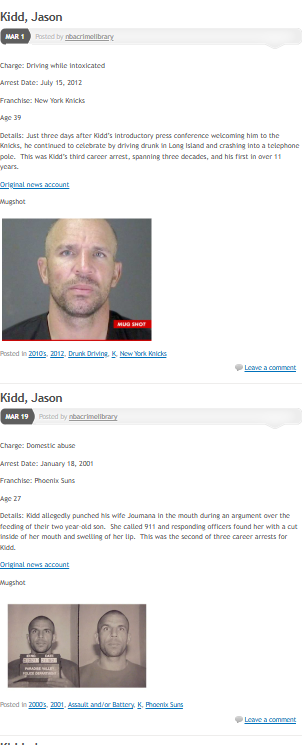




In [16]:

#Extract the official 'Reason for arrest' categories from the post by reading category links and matching their slug to the master list.
#Returns a single string like: "Drunk Driving | Resisting Arrest" (or None if no categories are found).
def extract_crimes_from_post(soup, master_crimes_by_slug):
    crimes = []
    for a in soup.select('a[href*="/category/5-reason-for-arrest/"]'):
        href = a.get("href", "")
        m = re.search(r"/category/5-reason-for-arrest/([^/]+)/?", href)
        if not m:
            continue
        slug = m.group(1)

        # Only keep slugs that exist in the master list
        if slug in master_crimes_by_slug:
            crimes.append(master_crimes_by_slug[slug])

    crimes = dedupe_keep_order(crimes)
    crimes_str = " | ".join(crimes) if crimes else None
    return crimes_str


**Parse a post into multiple arrest records**

In [17]:

#Download one post URL and return a list of dictionaries.
#Each dictionary = one arrest record found on that page.
#A new record begins at each "Charge:" line.
def parse_post_records(post_url, master_crimes_by_slug):
    soup = soup_from(post_url)

    player = format_player_name(get_player_name(soup))

    #Main content area (where the paragraphs live)
    content = soup.select_one(".entry-content") or soup

    #Crime category labels (from tags at bottom of post)
    crimes_str = extract_crimes_from_post(soup, master_crimes_by_slug)



    #Helper: determines whether a paragraph begins a new field.
    #Used to stop collecting multi-paragraph Details.

    def is_field_line(text_lower):
        return (
            text_lower.startswith("charge:") or
            text_lower.startswith("arrest date:") or
            text_lower.startswith("franchise:") or
            text_lower.startswith("age") or
            text_lower.startswith("details:")
        )

    paragraphs = content.find_all("p")


    #current record thats being built
    records = []
    current = None



    def start_new_record():
        return {
            "Player Name": player,
            "Arrest Date": None,
            "Charge": None,  # keep whole charge line (no exploding)
            "Crime Category": crimes_str,
            "Franchise": None,
            "Age": None,
            "Details": None,
            "Post URL": post_url,
        }

    i = 0
    while i < len(paragraphs):
        line = norm_ws(paragraphs[i].get_text(" ", strip=True))
        low = line.lower()


        #New record begins at "Charge:"
        if low.startswith("charge:"):

            if current is not None:
                records.append(current)
            current = start_new_record()
            current["Charge"] = line.split(":", 1)[1].strip() or None

        #Only fill fields if started a record (--> "Charge:" is seen)
        elif current is not None and low.startswith("arrest date:"):
            current["Arrest Date"] = line.split(":", 1)[1].strip() or None

        elif current is not None and low.startswith("franchise:"):
            current["Franchise"] = line.split(":", 1)[1].strip() or None

        elif current is not None and low.startswith("age"):
            #handles "Age: 23" and "Age 23"
            m = re.match(r"^age[:\s]+(\d+)\s*$", low)
            if m:
                current["Age"] = int(m.group(1))

        elif current is not None and low.startswith("details:"):
            first = line.split(":", 1)[1].strip()
            chunks = [first] if first else []

            j = i + 1
            while j < len(paragraphs):
                nxt = norm_ws(paragraphs[j].get_text(" ", strip=True))
                nxt_low = nxt.lower()
                if is_field_line(nxt_low):
                    break
                if nxt:
                    chunks.append(nxt)
                j += 1

            current["Details"] = " ".join(chunks).strip() if chunks else None
            i = j - 1  #jump ahead

        i += 1


    # Append the last record if it exists
    if current is not None:
        records.append(current)

    return records


## Building the full dataset (scraping all years)

Now that we can:
1) discover which “Year of arrest” pages exist,  
2) collect post URLs from each year page, and  
3) parse each post into one or more arrest records,  

we can build the full dataset.

Important implementation details:
- **Caching:** Because the same post URL can appear multiple times while iterating over categories, and because a single post can contain multiple arrests, I was AI-suggested to cache the parsed results of each post. This reduces redundant downloads and allows me to reuse the parsed records and filter them by the relevant year.
- **Year filtering:** some posts contain multiple arrests across different years. Because I am iterating over year pages, I only keep records whose extracted arrest year matches the year page being scraped.
- **Polite scraping:** I include a short delay between requests to avoid overloading the site.

At the end of this step, I save a CSV file containing one row per arrest record.


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
def extract_year_from_year_url(year_url):
    m = re.search(r"/category/2-year-of-arrest/(\d{4})/?", year_url)
    return int(m.group(1)) if m else None

def arrest_year_from_date(date_str):
    if not date_str:
        return None
    m = re.search(r"(\d{4})", str(date_str))
    return int(m.group(1)) if m else None


RUN_SCRAPE = False #Turned this off so I don't accidentally run the scrape again
CSV_PATH = "/content/drive/MyDrive/nba_crime_library_all_records.csv"

if RUN_SCRAPE:
    post_cache = {} #post_url -> list of parsed arrest-record dicts
    rows = []

    for idx, yurl in enumerate(year_urls, start=1):
        year = extract_year_from_year_url(yurl)
        print(f"\n[{idx}/{len(year_urls)}] Year:", year)

        post_urls = get_posts_from_category(yurl, max_pages=200)
        print("  posts:", len(post_urls))

        for u in post_urls:
           # Parse each post only once
            if u not in post_cache:
                try:
                    post_cache[u] = parse_post_records(u, master_crimes_by_slug)
                except Exception as e:
                    print("Failed post:", u, e)
                    post_cache[u] = []
                time.sleep(SLEEP)

            #Keep only the records that belong to this year page
            recs_for_year = [r for r in post_cache[u] if arrest_year_from_date(r.get("Arrest Date")) == year]
            rows.extend(recs_for_year)

    df_all = pd.DataFrame(rows)

    #Remove any accidental duplicates
    df_all = df_all.drop_duplicates(subset=["Player Name", "Arrest Date", "Charge", "Post URL"]).reset_index(drop=True)

    #normalize dash character for consistent grouping
    df_all["Crime Category"] = df_all["Crime Category"].str.replace("–", "-", regex=False)

    df_all.to_csv(CSV_PATH, index=False)
    print("Saved:", CSV_PATH, "| rows:", len(df_all))

else:
    df_all = pd.read_csv(CSV_PATH)
    print("Loaded:", CSV_PATH, "| rows:", len(df_all))

df_all.head()


Loaded: /content/drive/MyDrive/nba_crime_library_all_records.csv | rows: 306


,Player Name,Arrest Date,Charge,Crime Category,Franchise,Age,Details,Post URL,Arrest Year,Arrest Decade,Arrest Month,Arrest Month Name
0,Ralph Beard,"October 20, 1951",Gambling,Gambling,Indianapolis Olympians,23.0,Beard and fellow Olympians teammate Alex Groza...,https://nbacrimelibrary.com/2011/02/04/beard-r...,1951.0,1950.0,10.0,October
1,Alex Groza,"October 20, 1951",Gambling,Gambling,Indianapolis Olympians,25.0,Groza and fellow Olympians teammate Ralph Bear...,https://nbacrimelibrary.com/2011/02/04/groza-a...,1951.0,1950.0,10.0,October
2,Joe Fulks,"June 4, 1953",Driving Under the Influence,Drunk Driving,Golden State Warriors,31.0,NaN,https://nbacrimelibrary.com/2011/02/05/fulks-joe/,1953.0,1950.0,6.0,June
3,Reggie Harding,"September 8, 1965",Loitering in a Place of Illegal Occupation,Loitering,Detroit Pistons,23.0,NaN,https://nbacrimelibrary.com/2011/02/05/harding...,1965.0,1960.0,9.0,September
4,Reggie Harding,"September 6, 1965",Assault and Battery,Assault and/or Battery,Detroit Pistons,23.0,After several run-ins with the law before goin...,https://nbacrimelibrary.com/2011/02/05/harding...,1965.0,1960.0,9.0,September


In this step, I clean and enrich the scraped arrest records so they are easier to analyze.

The original Arrest Date column is stored as text (e.g “October 20, 1951”). I convert the date string into a proper datetime value and derive:

Arrest Year (e.g 1951)

Arrest Decade (e.g 1950)

Arrest Month (1–12)

Arrest Month Name (e.g “October”)

Finally, I ensure "Age" is stored as a numeric integer type (but still allows missing values). This makes it easier to compute summary statistics and create plots.

**Feature engineering (year/decade/month) + types**

In [30]:
# Parse dates
df_all["Arrest Date Parsed"] = pd.to_datetime(df_all["Arrest Date"], errors="coerce")

# Year/Decade/Month
df_all["Arrest Year"] = df_all["Arrest Date Parsed"].dt.year.astype("Int64")
df_all["Arrest Decade"] = (df_all["Arrest Year"] // 10 * 10).astype("Int64")
df_all["Arrest Month"] = df_all["Arrest Date Parsed"].dt.month.astype("Int64")
df_all["Arrest Month Name"] = df_all["Arrest Date Parsed"].dt.month_name()

#Age as integer
df_all["Age"] = pd.to_numeric(df_all["Age"], errors="coerce").astype("Int64")

#Drop helper
df_all = df_all.drop(columns=["Arrest Date Parsed"])

#Checks
print("Missing core fields:")
print(df_all[["Player Name","Arrest Date","Charge","Crime Category"]].isna().sum())

df_all.head()


Missing core fields:
Player Name       0
Arrest Date       0
Charge            0
Crime Category    0
dtype: int64


,Player Name,Arrest Date,Charge,Crime Category,Franchise,Age,Details,Post URL,Arrest Year,Arrest Decade,Arrest Month,Arrest Month Name
0,Ralph Beard,"October 20, 1951",Gambling,Gambling,Indianapolis Olympians,23,Beard and fellow Olympians teammate Alex Groza...,https://nbacrimelibrary.com/2011/02/04/beard-r...,1951,1950,10,October
1,Alex Groza,"October 20, 1951",Gambling,Gambling,Indianapolis Olympians,25,Groza and fellow Olympians teammate Ralph Bear...,https://nbacrimelibrary.com/2011/02/04/groza-a...,1951,1950,10,October
2,Joe Fulks,"June 4, 1953",Driving Under the Influence,Drunk Driving,Golden State Warriors,31,NaN,https://nbacrimelibrary.com/2011/02/05/fulks-joe/,1953,1950,6,June
3,Reggie Harding,"September 8, 1965",Loitering in a Place of Illegal Occupation,Loitering,Detroit Pistons,23,NaN,https://nbacrimelibrary.com/2011/02/05/harding...,1965,1960,9,September
4,Reggie Harding,"September 6, 1965",Assault and Battery,Assault and/or Battery,Detroit Pistons,23,After several run-ins with the law before goin...,https://nbacrimelibrary.com/2011/02/05/harding...,1965,1960,9,September


## 3. Dataset augmentation (player profile + performance variables)

I augment the scraped NBA Crime Library dataset with additional player information (e.g., position, height, draft number, and basic performance stats like PTS/REB/AST) using a public Kaggle dataset.

Because the two datasets do not share a common unique identifier, I merge them using player names. To make name matching more robust, I create a normalized name key in both datasets by:






*   lowercasing
*   removing punctuation and extra whitespace
*   removing common suffixes (Jr, Sr, II, III, etc.)

After merging, I compute the match rate (what proportion of arrest records were successfully linked to a player in the Kaggle dataset). This augmented dataset allows for additional exploratory analysis about the "criminals"

In [31]:

#Everything copied from the relevant Kaggle-page
import kagglehub
import os

path = kagglehub.dataset_download("yagizfiratt/nba-players-database")
print("Dataset path:", path)
print("Files:", os.listdir(path))

file_path = os.path.join(path, "PlayerIndex_nba_stats.csv")
nba = pd.read_csv(file_path)
nba.head()


Using Colab cache for faster access to the 'nba-players-database' dataset.
Dataset path: /kaggle/input/nba-players-database
Files: ['PlayerIndex_nba_stats.csv']


,PERSON_ID,PLAYER_LAST_NAME,PLAYER_FIRST_NAME,PLAYER_SLUG,TEAM_ID,TEAM_SLUG,IS_DEFUNCT,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,...,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,ROSTER_STATUS,PTS,REB,AST,STATS_TIMEFRAME,FROM_YEAR,TO_YEAR
0,76001,Abdelnaby,Alaa,alaa-abdelnaby,1610612757,blazers,0,Portland,Trail Blazers,POR,...,1990.0,1.0,25.0,NaN,5.7,3.3,0.3,Career,1990,1994
1,76002,Abdul-Aziz,Zaid,zaid-abdul-aziz,1610612745,rockets,0,Houston,Rockets,HOU,...,1968.0,1.0,5.0,NaN,9.0,8.0,1.2,Career,1968,1977
2,76003,Abdul-Jabbar,Kareem,kareem-abdul-jabbar,1610612747,lakers,0,Los Angeles,Lakers,LAL,...,1969.0,1.0,1.0,NaN,24.6,11.2,3.6,Career,1969,1988
3,51,Abdul-Rauf,Mahmoud,mahmoud-abdul-rauf,1610612743,nuggets,0,Denver,Nuggets,DEN,...,1990.0,1.0,3.0,NaN,14.6,1.9,3.5,Career,1990,2000
4,1505,Abdul-Wahad,Tariq,tariq-abdul-wahad,1610612758,kings,0,Sacramento,Kings,SAC,...,1997.0,1.0,11.0,NaN,7.8,3.3,1.1,Career,1997,2003


**Normalize names + merge + match rate**

In [32]:
#Goal: Creating a robust join key from a player name
def normalize_name(s: str) -> str:
    if pd.isna(s):
        return ""
    s = s.lower().strip()

    #remove common suffixes found in the players names (jr, sr, ii, iii, iv, v)
    s = re.sub(r"\b(jr|sr|ii|iii|iv|v)\b\.?", "", s)

    # remove punctuation/hyphens/apostrophes
    s = re.sub(r"[^a-z0-9\s]", " ", s)

    #collapse multiple spaces into one
    s = re.sub(r"\s+", " ", s).strip()
    return s

#Create name key in crime dataset
df_all["name_key"] = df_all["Player Name"].apply(normalize_name)

#Create name key in Kaggle dataset
nba["Player Name Kaggle"] = (nba["PLAYER_FIRST_NAME"].fillna("") + " " + nba["PLAYER_LAST_NAME"].fillna("")).str.strip()
nba["name_key"] = nba["Player Name Kaggle"].apply(normalize_name)

#Drop columns that are unneccessary
kaggle_keep = [
    "PERSON_ID","PLAYER_FIRST_NAME","PLAYER_LAST_NAME",
    "TEAM_ID","TEAM_CITY","ROSTER_STATUS",
    "POSITION","HEIGHT","WEIGHT","COLLEGE","COUNTRY",
    "DRAFT_YEAR","DRAFT_ROUND","DRAFT_NUMBER",
    "PTS","REB","AST"
]
nba_small = nba[kaggle_keep + ["name_key"]].copy()

#Merge: keep all arrest records and attach stats where possible
df_merged = df_all.merge(nba_small, on="name_key", how="left")

#Match rate (to check how many of the records from NBA Criminal file that were found in the Kaggle one)
match_rate = df_merged["PERSON_ID"].notna().mean()
print("Match rate:", match_rate)

df_merged.head()


Match rate: 0.9716088328075709


,Player Name,Arrest Date,Charge,Crime Category,Franchise,Age,Details,Post URL,Arrest Year,Arrest Decade,...,HEIGHT,WEIGHT,COLLEGE,COUNTRY,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,PTS,REB,AST
0,Ralph Beard,"October 20, 1951",Gambling,Gambling,Indianapolis Olympians,23,Beard and fellow Olympians teammate Alex Groza...,https://nbacrimelibrary.com/2011/02/04/beard-r...,1951,1950,...,5-10,175.0,Kentucky,USA,1949.0,2.0,NaN,15.9,3.8,4.4
1,Alex Groza,"October 20, 1951",Gambling,Gambling,Indianapolis Olympians,25,Groza and fellow Olympians teammate Ralph Bear...,https://nbacrimelibrary.com/2011/02/04/groza-a...,1951,1950,...,6-7,218.0,Kentucky,USA,1949.0,1.0,2.0,22.5,10.7,2.4
2,Joe Fulks,"June 4, 1953",Driving Under the Influence,Drunk Driving,Golden State Warriors,31,NaN,https://nbacrimelibrary.com/2011/02/05/fulks-joe/,1953,1950,...,6-5,190.0,Murray State,USA,NaN,NaN,NaN,16.4,5.3,1.2
3,Reggie Harding,"September 8, 1965",Loitering in a Place of Illegal Occupation,Loitering,Detroit Pistons,23,NaN,https://nbacrimelibrary.com/2011/02/05/harding...,1965,1960,...,7-0,249.0,Eastern HS (MI),USA,1963.0,6.0,48.0,9.0,9.1,1.7
4,Reggie Harding,"September 6, 1965",Assault and Battery,Assault and/or Battery,Detroit Pistons,23,After several run-ins with the law before goin...,https://nbacrimelibrary.com/2011/02/05/harding...,1965,1960,...,7-0,249.0,Eastern HS (MI),USA,1963.0,6.0,48.0,9.0,9.1,1.7


## Exploratory Data Analysis (EDA)

Although there are many possibilities to explore, I focus on the questions I am most curious about:

1. **Type of crimes**  
   - What are the most common crime categories?  
   - Do the free-text incident narratives (`Details`) reveal recurring themes?

2. **Augmentation:**  
    Can these arrest records be enriched with basic player information (e.g., position, height/weight, draft data, and summary performance stats), and do any descriptive patterns emerge when comparing crime categories across player “profiles”?



### 1.1 Most common crime categories

I start by counting how often each official “Crime Category” occurs in the dataset.  
Each row in the dataset represents one arrest record, so these counts reflect how many arrest records are assigned to each category.


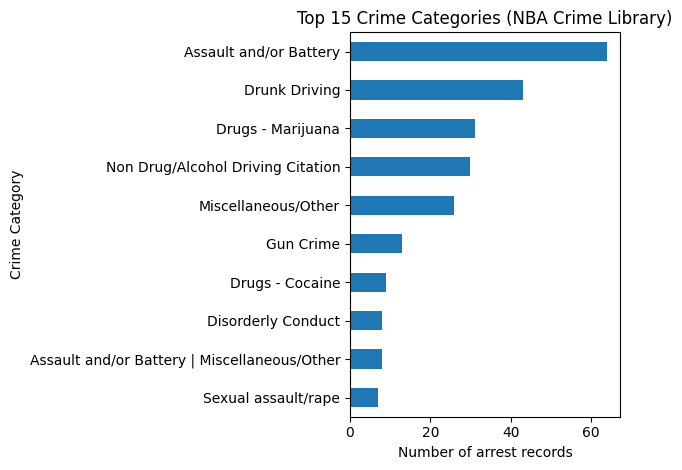

In [84]:
import matplotlib.pyplot as plt

# Count number of arrest records per crime category
top_crimes = df_merged["Crime Category"].value_counts().head(10)
top_crimes

plt.figure()
top_crimes.sort_values().plot(kind="barh")
plt.title("Top 15 Crime Categories (NBA Crime Library)")
plt.xlabel("Number of arrest records")
plt.tight_layout()
plt.show()



As seen above, the three most common are 'Assault and/or Battery', 'Drunk Driving', and 'Drugs/Marijuana'

### 1.2 Word clouds: exploring the incident narratives (`Details`)
Next, I explore the free-text `Details` column, which contains a short narrative about each incident.

With inspiration from the course book [Computational Analysis of Communication](https://cssbook.net/content/) (chapter 7/10)- to get an initial sense of common themes, I generate **word clouds** for the three most frequent crime categories.

To make the word clouds more meaningful, I remove:
- standard English stopwords (e.g., “the”, “and”)
- website-related “boilerplate” words (e.g., “permalink”, “wordpress”)
- terms that are too generic in this context (e.g., “arrested”, “police”)
- team/city names that would otherwise dominate the visualization





In [34]:
!pip install ufal.udpipe nagisa conllu wordcloud gensim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 85.5 MB/s eta 0:00:00


In [85]:
# Copy-pasted recommended packages from the book
# Standard library and basic data wrangling
import os
import sys
import urllib
import urllib.request
import re
import regex
import pandas as pd
import numpy as np

# Tokenization
import nltk
from nltk.tokenize import TreebankWordTokenizer, WhitespaceTokenizer
from nltk.corpus import stopwords

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['anderson', 'antonio', 'atlanta', 'baltimore', 'boston', 'brooklyn', 'charlotte', 'chicago', 'city', 'cleveland', 'dallas', 'denver', 'detroit', 'golden', 'houston', 'indianapolis', 'los', 'louis', 'memphis', 'miami', 'milwaukee', 'minnesota', 'new', 'oklahoma', 'orlando', 'orleans', 'philadelphia', 'phoenix', 'pittsburgh', 'portland', 'providence', 'sacramento', 'san', 'sheboygan', 'state', 'toronto', 'utah', 'washington', 'waterloo', 'york'] not in stop_words.
  warnings.warn(


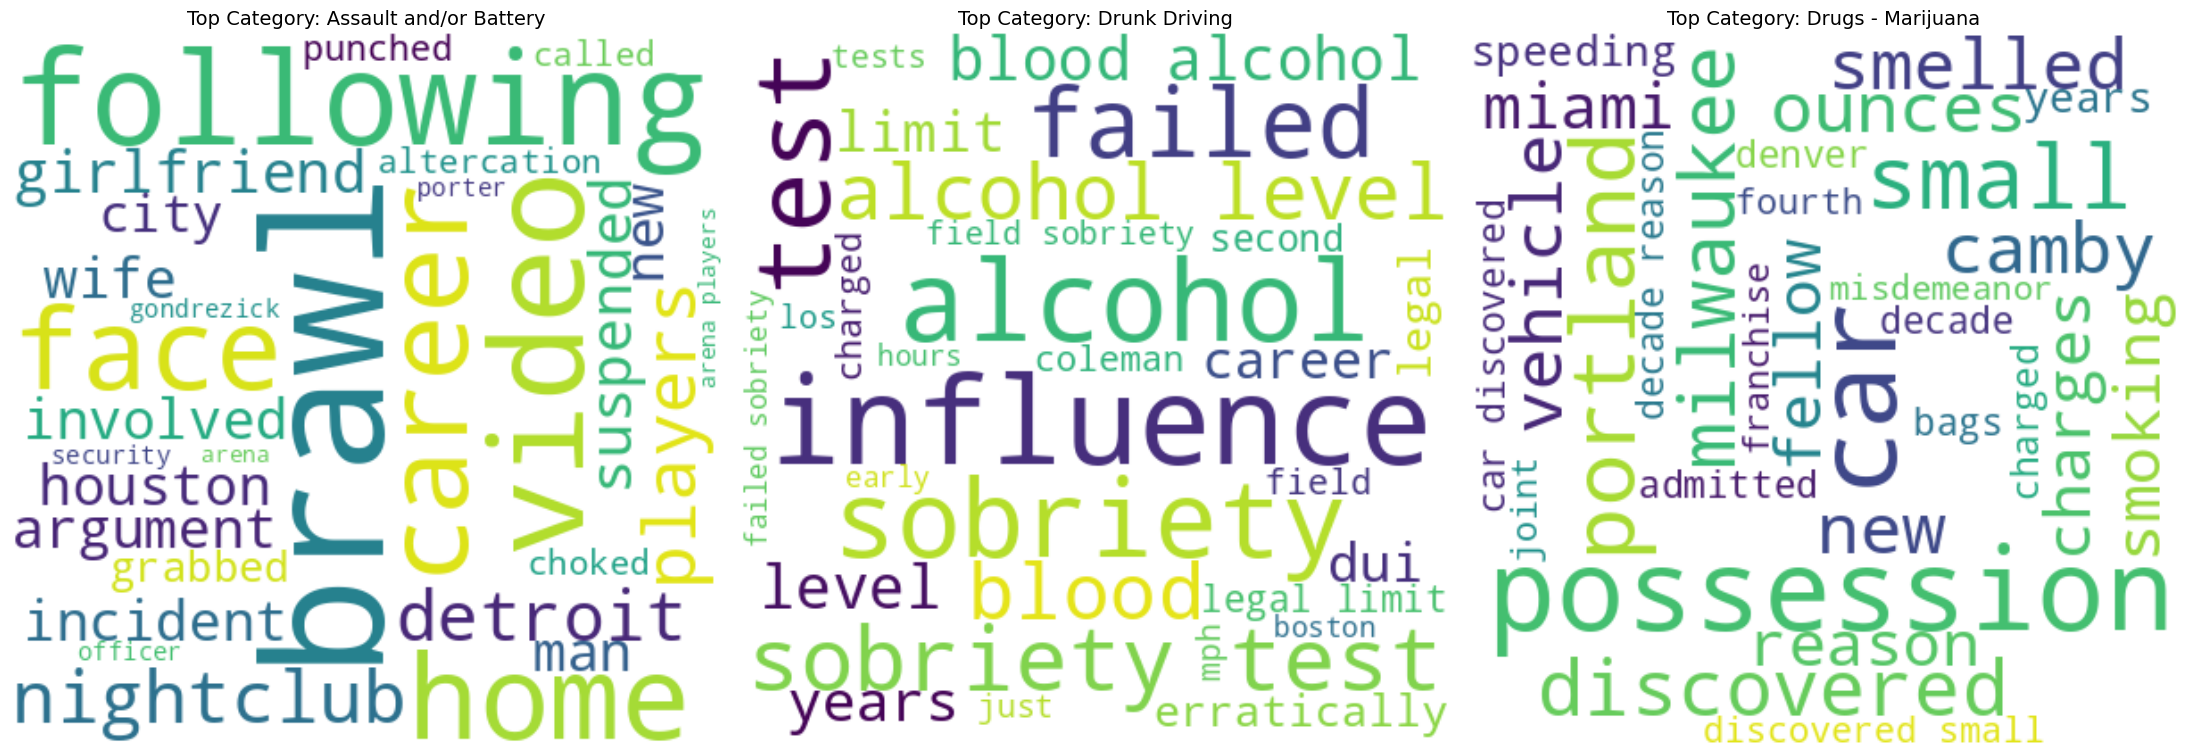

In [69]:
#Got some additional recommendations from Gemini on what to download (some of the books material was outdated)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
import matplotlib.pyplot as plt
from wordcloud import WordCloud

top_3_categories = top_crimes.index[:3].tolist()
fig, axes = plt.subplots(1, 3, figsize=(22, 8))


# Removing stop words
stop_words = list(text.ENGLISH_STOP_WORDS)

# Subjective choice of words additionally to the English words
'''
I chose to remove words that were likely related to

1) The website itself and
2) general legal/law enforcement words that appeared in all three categories
(given that the subject itself is regarding crime I argue that this not bring any interesting insights)

'''
my_custom_words = [
    "permalink","wordpress","posted","comment","create","website",
    "original","news","blog","com",
    "driving","assault","battery","drugs","drug","marijuana",
    "bookmark","account","drunk","pulled","arrest","arrested",
    "leave","mugshot","free","later","officers","police","allegedly",

    # team/city terms (copypasted from the Kaggle Dataset)
    "los angeles","angeles","blazers","rockets","lakers","nuggets","kings",
    "grizzlies","warriors","sixers","thunder","knicks","clippers","magic",
    "suns","pistons","nets","hawks","heat","cavaliers","hornets","raptors",
    "mavericks","celtics","pelicans","wizards","spurs","bucks",
    "timberwolves","bulls","pacers","jazz","trailblazers",
    "portland","houston","denver","sacramento","memphis","philadelphia",
    "pittsburgh","oklahoma city","new york","orlando","phoenix","detroit",
    "brooklyn","atlanta","miami","cleveland","charlotte","toronto","dallas",
    "boston","new orleans","washington","san antonio","milwaukee",
    "minnesota","chicago","indiana","utah","baltimore","st louis",
    "indianapolis","providence","waterloo","sheboygan","anderson"
]

#Force everything to lowercase
clean_custom_list = [word.lower() for word in my_custom_words]

#Merge the custom words to the English list
#Add the new list to the existing one with extend()
stop_words.extend(my_custom_words)


#Vectorizer used to count words/bigrams for each category
cv = CountVectorizer(
    stop_words=stop_words, #This now contains both
    token_pattern=r'[a-zA-Z]{3,}',
    lowercase=True,
    min_df=2,
    max_df=0.6,
    #tried adding ngram rule (allowing one/two-word phrases to see if interpretability changes)
    ngram_range=(1,2)
)

for i, category in enumerate(top_3_categories):
    #Filter data for the category
    subset = df_merged[df_merged["Crime Category"] == category]["Details"].dropna()

    if not subset.empty:
        #CountVectorizer do the cleaning/counting
        #Transform the text into a matrix of counts
        word_matrix = cv.fit_transform(subset)

        #Sum the counts for each word to get total frequencies
        word_counts = dict(zip(cv.get_feature_names_out(), word_matrix.toarray().sum(axis=0)))

        #Generate the cloud using 'generate_from_frequencies'
        wc = WordCloud(
            width=400,
            height=400,
            background_color='white',
            max_words=30
        ).generate_from_frequencies(word_counts)

        axes[i].imshow(wc, interpolation='bilinear')
        axes[i].set_title(f"Top Category: {category}", fontsize=14)

    axes[i].axis('off')

plt.tight_layout()
plt.show()

### 1.3 Topic modeling (LDA) on `Details` (also inspiration from the CCS-book as linked above)

Word clouds show frequent terms, but they do not summarize how words cluster into themes across documents.

To explore recurring narrative themes in the `Details` text, I fit a topic model using **Latent Dirichlet Allocation (LDA)**.  
LDA represents each document as a mixture of topics, and each topic as a distribution over words/phrases.

This is an exploratory technique: topics reflect how incidents are described on the website, not official legal categories.


In [70]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import text
import numpy as np
import pandas as pd

## Prepare text: only possible to model documents that have narrative text
docs = df_merged["Details"].dropna().astype(str)
print("Documents with Details:", len(docs))

#Stopwords (same as before)
stop_words = list(text.ENGLISH_STOP_WORDS)
stop_words.extend(my_custom_words)

#Vectorize
cv = CountVectorizer(
    stop_words=stop_words,
    token_pattern=r"[a-zA-Z]{3,}",
    min_df=3,          # ignore very rare words
    max_df=0.6,         # ignore extremely common words
    ngram_range=(1,2)
)
X = cv.fit_transform(docs)

#Fit LDA
n_topics = 6  #Subjective number (chosen as a suitable (not too ambitious amount) for interpretability)
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method="batch"
)
lda.fit(X)

#Show top words per topic
feature_names = cv.get_feature_names_out()

def show_topics(model, feature_names, n_top_words=10):
    rows = []
    for topic_idx, topic in enumerate(model.components_):
        top_idx = topic.argsort()[::-1][:n_top_words]
        rows.append({
            "Topic": topic_idx,
            "Top words": ", ".join(feature_names[i] for i in top_idx)
        })
    return pd.DataFrame(rows)

topics_df = show_topics(lda, feature_names, n_top_words=12)
topics_df


Documents with Details: 252


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['anderson', 'antonio', 'atlanta', 'baltimore', 'boston', 'brooklyn', 'charlotte', 'chicago', 'city', 'cleveland', 'dallas', 'denver', 'detroit', 'golden', 'houston', 'indianapolis', 'los', 'louis', 'memphis', 'miami', 'milwaukee', 'minnesota', 'new', 'oklahoma', 'orlando', 'orleans', 'philadelphia', 'phoenix', 'pittsburgh', 'portland', 'providence', 'sacramento', 'san', 'sheboygan', 'state', 'toronto', 'utah', 'washington', 'waterloo', 'york'] not in stop_words.
  warnings.warn(


,Topic,Top words
0,0,"year, year old, old, rape, second, nba, gondre..."
1,1,"license, gun, new, car, vehicle, crime, citati..."
2,2,"following, video, career, charges, milwaukee, ..."
3,3,"alcohol, mph, citation, non alcohol, alcohol c..."
4,4,"disorderly, conduct, disorderly conduct, misce..."
5,5,"brawl, players, video, suspended, new, coleman..."


### 1.4 Topic probabilities per incident

LDA does not assign a single topic label to each incident.  
Instead, it returns a probability distribution over topics for each `Details` document.

To analyze topics systematically, I create a combined table that contains:
- metadata (crime category, year, etc.)
- topic probabilities (Topic 0 … Topic 5)
- the dominant topic (highest probability per document)


In [74]:
topic_probs = lda.transform(X)
topic_cols = [f"Topic {i}" for i in range(topic_probs.shape[1])]
topics = pd.DataFrame(topic_probs, columns=topic_cols, index=docs.index)

meta_cols = ["Player Name","Crime Category","Arrest Year","Arrest Decade","TEAM_CITY","Post URL"]
meta = df_merged.loc[docs.index, meta_cols].copy()

tpd = pd.concat([meta.reset_index(drop=True), topics.reset_index(drop=True)], axis=1)
tpd["Main topic"] = tpd[topic_cols].values.argmax(axis=1)

tpd.head()


,Player Name,Crime Category,Arrest Year,Arrest Decade,TEAM_CITY,Post URL,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Main topic
0,Ralph Beard,Gambling,1951,1950,Indianapolis,https://nbacrimelibrary.com/2011/02/04/beard-r...,0.007588,0.007588,0.007597,0.007588,0.007608,0.962031,5
1,Alex Groza,Gambling,1951,1950,Indianapolis,https://nbacrimelibrary.com/2011/02/04/groza-a...,0.007258,0.007257,0.007265,0.007258,0.007282,0.963679,5
2,Reggie Harding,Assault and/or Battery,1965,1960,Detroit,https://nbacrimelibrary.com/2011/02/05/harding...,0.009330,0.009295,0.009398,0.656629,0.306009,0.009339,3
3,Dick Garrett,Drugs - Cocaine | Loitering,1972,1970,NaN,https://nbacrimelibrary.com/2011/02/05/garrett...,0.020916,0.020925,0.021033,0.894847,0.021174,0.021105,3
4,Harold Fox,Loitering,1972,1970,LA,https://nbacrimelibrary.com/2011/02/05/fox-har...,0.023878,0.023933,0.024080,0.879656,0.024321,0.024131,3


In [88]:
import pandas as pd

# Topic probabilities for each document
topic_probs = lda.transform(X)

#Column names: "Topic 0", "Topic 1" etc
topic_cols = [f"Topic {i}" for i in range(topic_probs.shape[1])]

#DataFrame of topic probabilities
topics = pd.DataFrame(topic_probs, columns=topic_cols, index=docs.index)

#Metadata aligned to the same rows as docs
meta_cols = ["Player Name", "Crime Category", "Arrest Year", "Arrest Decade", "TEAM_CITY", "Post URL"]
meta = df_merged.loc[docs.index, meta_cols].copy()

# Combine into one table (tpd = topic-probability dataframe)
tpd = pd.concat([meta.reset_index(drop=True), topics.reset_index(drop=True)], axis=1)

#Dominant topic = topic with highest probability for that row
tpd["Main topic"] = tpd[topic_cols].values.argmax(axis=1)

tpd.head()


,Player Name,Crime Category,Arrest Year,Arrest Decade,TEAM_CITY,Post URL,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Main topic
0,Ralph Beard,Gambling,1951,1950,Indianapolis,https://nbacrimelibrary.com/2011/02/04/beard-r...,0.007588,0.007588,0.007597,0.007588,0.007608,0.962031,5
1,Alex Groza,Gambling,1951,1950,Indianapolis,https://nbacrimelibrary.com/2011/02/04/groza-a...,0.007258,0.007257,0.007265,0.007258,0.007282,0.963679,5
2,Reggie Harding,Assault and/or Battery,1965,1960,Detroit,https://nbacrimelibrary.com/2011/02/05/harding...,0.009330,0.009295,0.009398,0.656629,0.306009,0.009339,3
3,Dick Garrett,Drugs - Cocaine | Loitering,1972,1970,NaN,https://nbacrimelibrary.com/2011/02/05/garrett...,0.020916,0.020925,0.021033,0.894847,0.021174,0.021105,3
4,Harold Fox,Loitering,1972,1970,LA,https://nbacrimelibrary.com/2011/02/05/fox-har...,0.023878,0.023933,0.024080,0.879656,0.024321,0.024131,3


### 1.5 Do topics align with official crime categories?

To connect the unsupervised topics back to the structured dataset, I compute the **average topic distribution per crime category** (for the top 10 most common categories).

If the topics capture meaningful narrative structure, categories like “Gun Crime” or “Drunk Driving” should concentrate strongly in specific topics.


In [89]:
top10 = tpd["Crime Category"].value_counts().head(10).index

topic_means = (tpd[tpd["Crime Category"].isin(top10)]
               .groupby("Crime Category")[topic_cols]
               .mean()
               .round(3))

topic_means


,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
Crime Category,,,,,,
Assault and/or Battery,0.203,0.095,0.241,0.035,0.225,0.201
Assault and/or Battery | Miscellaneous/Other,0.287,0.132,0.259,0.037,0.276,0.009
Disorderly Conduct,0.132,0.007,0.157,0.087,0.610,0.007
Disorderly Conduct | Miscellaneous/Other,0.142,0.008,0.008,0.075,0.759,0.008
Drugs - Marijuana,0.079,0.413,0.189,0.144,0.101,0.074
Drunk Driving,0.022,0.120,0.097,0.650,0.036,0.075
Gun Crime,0.039,0.766,0.089,0.055,0.042,0.009
Miscellaneous/Other,0.037,0.328,0.224,0.130,0.164,0.116
Non Drug/Alcohol Driving Citation,0.046,0.359,0.067,0.489,0.017,0.021


In [75]:
top10 = tpd["Crime Category"].value_counts().head(10).index
(topic_means := tpd[tpd["Crime Category"].isin(top10)]
 .groupby("Crime Category")[topic_cols]
 .mean()
 .round(3))


,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
Crime Category,,,,,,
Assault and/or Battery,0.203,0.095,0.241,0.035,0.225,0.201
Assault and/or Battery | Miscellaneous/Other,0.287,0.132,0.259,0.037,0.276,0.009
Disorderly Conduct,0.132,0.007,0.157,0.087,0.610,0.007
Disorderly Conduct | Miscellaneous/Other,0.142,0.008,0.008,0.075,0.759,0.008
Drugs - Marijuana,0.079,0.413,0.189,0.144,0.101,0.074
Drunk Driving,0.022,0.120,0.097,0.650,0.036,0.075
Gun Crime,0.039,0.766,0.089,0.055,0.042,0.009
Miscellaneous/Other,0.037,0.328,0.224,0.130,0.164,0.116
Non Drug/Alcohol Driving Citation,0.046,0.359,0.067,0.489,0.017,0.021


### 1.7 How strongly does each category align with a single topic?

Finally, I summarize how “topic-focused” each crime category is by:
- finding the dominant topic for that category (highest mean probability)
- plotting the dominant mean probability

A high value suggests the category is described in a consistent narrative theme.


In [90]:
top10 = tpd["Crime Category"].value_counts().head(10).index
topic_means = (tpd[tpd["Crime Category"].isin(top10)]
               .groupby("Crime Category")[topic_cols]
               .mean())

dominant_topic = topic_means.idxmax(axis=1).str.replace("Topic ", "").astype(int)
dominant_strength = topic_means.max(axis=1)

summary = (pd.DataFrame({
    "Dominant topic": dominant_topic,
    "Dominant mean prob": dominant_strength
}).sort_values("Dominant mean prob", ascending=False))

summary


,Dominant topic,Dominant mean prob
Crime Category,,
Gun Crime,1,0.765753
Disorderly Conduct | Miscellaneous/Other,4,0.758873
Drunk Driving,3,0.650147
Disorderly Conduct,4,0.610296
Sexual assault/rape,0,0.582445
Non Drug/Alcohol Driving Citation,3,0.489491
Drugs - Marijuana,1,0.413143
Miscellaneous/Other,1,0.328478
Assault and/or Battery | Miscellaneous/Other,0,0.286529


In [80]:
for t in range(n_topics):
    ex = (tpd[tpd["Main topic"] == t]
          .sort_values(f"Topic {t}", ascending=False)
          .drop_duplicates(subset=["Post URL"])
          .head(2))
    print(f"\n=== Topic {t} examples (unique posts) ===")
    display(ex[["Player Name","Crime Category","Arrest Year",f"Topic {t}","Post URL"]])




=== Topic 0 examples (unique posts) ===


,Player Name,Crime Category,Arrest Year,Topic 0,Post URL
250,Kevin Porter Jr,Assault and/or Battery,2023,0.980995,https://nbacrimelibrary.com/2023/09/11/porter-...
20,Jay Humphries,Drugs - Cocaine,1987,0.979659,https://nbacrimelibrary.com/2011/02/05/humphri...



=== Topic 1 examples (unique posts) ===


,Player Name,Crime Category,Arrest Year,Topic 1,Post URL
242,Malik Beasley,Drugs - Marijuana | Gun Crime | Miscellaneous/...,2020,0.975339,https://nbacrimelibrary.com/2021/06/17/beasley...
54,Corie Blount,Non Drug/Alcohol Driving Citation,1996,0.967805,https://nbacrimelibrary.com/2011/02/05/blount-...



=== Topic 2 examples (unique posts) ===


,Player Name,Crime Category,Arrest Year,Topic 2,Post URL
239,Kevin Porter Jr,Drugs - Marijuana | Gun Crime,2020,0.967790,https://nbacrimelibrary.com/2021/06/17/porter-...
214,Marcus Morris,Assault and/or Battery,2015,0.962013,https://nbacrimelibrary.com/2015/04/22/morris-...



=== Topic 3 examples (unique posts) ===


,Player Name,Crime Category,Arrest Year,Topic 3,Post URL
35,Charles Smith,Drunk Driving | Homicide,1991,0.985612,https://nbacrimelibrary.com/2011/02/05/smith-c...
128,Antonio Burks,Non Drug/Alcohol Driving Citation,2006,0.972999,https://nbacrimelibrary.com/2013/03/01/burks-a...



=== Topic 4 examples (unique posts) ===


,Player Name,Crime Category,Arrest Year,Topic 4,Post URL
79,Olden Polynice,Disorderly Conduct | Miscellaneous/Other,2000,0.968959,https://nbacrimelibrary.com/2012/03/16/polynic...
46,Luther Wright,Disorderly Conduct,1994,0.966528,https://nbacrimelibrary.com/2011/02/05/wright-...



=== Topic 5 examples (unique posts) ===


,Player Name,Crime Category,Arrest Year,Topic 5,Post URL
116,Stephen Jackson,Assault and/or Battery,2004,0.979661,https://nbacrimelibrary.com/2013/03/01/jackson...
114,Jermaine O’Neal,Assault and/or Battery,2004,0.978060,https://nbacrimelibrary.com/2013/03/01/oneal-j...


In [81]:
top10 = tpd["Crime Category"].value_counts().head(10).index
topic_means = (tpd[tpd["Crime Category"].isin(top10)]
               .groupby("Crime Category")[topic_cols]
               .mean())

dominant_topic = topic_means.idxmax(axis=1).str.replace("Topic ", "").astype(int)
dominant_strength = topic_means.max(axis=1)

summary = pd.DataFrame({
    "Dominant topic": dominant_topic,
    "Dominant mean prob": dominant_strength
}).sort_values("Dominant mean prob", ascending=False)

summary


,Dominant topic,Dominant mean prob
Crime Category,,
Gun Crime,1,0.765753
Disorderly Conduct | Miscellaneous/Other,4,0.758873
Drunk Driving,3,0.650147
Disorderly Conduct,4,0.610296
Sexual assault/rape,0,0.582445
Non Drug/Alcohol Driving Citation,3,0.489491
Drugs - Marijuana,1,0.413143
Miscellaneous/Other,1,0.328478
Assault and/or Battery | Miscellaneous/Other,0,0.286529


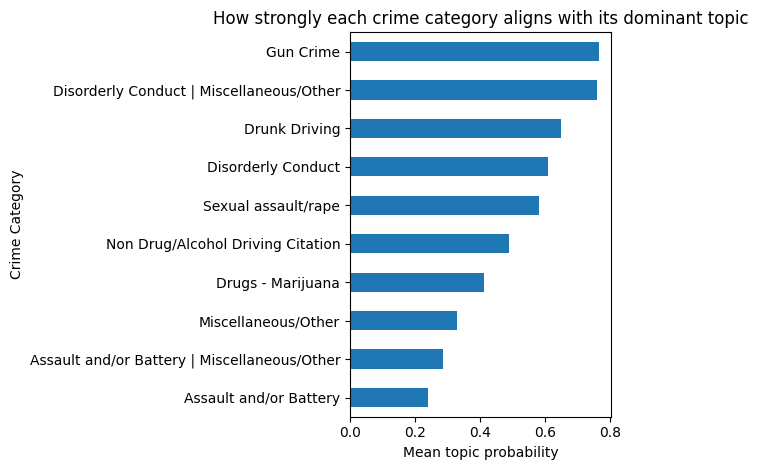

In [82]:
import matplotlib.pyplot as plt

plt.figure()
summary["Dominant mean prob"].sort_values().plot(kind="barh")
plt.title("How strongly each crime category aligns with its dominant topic")
plt.xlabel("Mean topic probability")
plt.tight_layout()
plt.show()


# Interpretation
The mean topic distributions show that several official crime categories align strongly with single topics, and the top words per topic make these alignments easy to interpret. Gun Crime concentrates in Topic 1 (0.766), whose most characteristic terms include license, gun, vehicle, citation, and alcohol citation, suggesting a consistent “weapons/traffic-enforcement” narrative style. Drunk Driving concentrates in Topic 3 (0.650), dominated by terms such as alcohol, mph, influence, sobriety test, and failed, which matches classic DUI-style incident descriptions. Disorderly Conduct concentrates in Topic 4 (0.610), whose top words (disorderly conduct, nightclub, outside, street, resisting, oklahoma city) reflect nightlife/public-disturbance narratives. Sexual assault/rape aligns most strongly with Topic 0 (0.582), characterized by terms like rape, sexual, year old, indicating legal-case narratives involving sexual assault. In contrast, broader categories such as Miscellaneous/Other and Assault and/or Battery are distributed across multiple topics (e.g., Topic 2 terms like charges, girlfriend, woman, video and Topic 5 terms like brawl, players, suspended), which is expected given that these labels cover a wider variety of incident types and storytelling patterns in the Details texts.

## Part 2 of EDA: Augmented analysis: Do crime categories differ by player position?

So far, the analysis focused on the crime data itself. Next, I use the augmented player database (Kaggle) to explore whether incident patterns differ by **player role**, using the `POSITION` variable.

Important note: this is descriptive. A player’s position does not “cause” a crime category. The goal is simply to explore whether certain categories are more associated with certain player archetypes (guards/forwards/centers) in this dataset.

Because the Kaggle dataset sometimes stores hybrid positions (e.g., `F-G`, `G-F`), I map positions into three broad buckets:

- Guard
- Forward
- Center


In [93]:
import pandas as pd
import numpy as np

def bucket_position(pos):
    """
    Map Kaggle position strings into broad categories:
    Guard / Forward / Center

    Examples:
      "G" -> Guard
      "F-G" -> Guard (contains G)
      "C-F" -> Center (contains C)
      "F" -> Forward
      NaN -> NaN
    """
    if pd.isna(pos):
        return np.nan

    pos = str(pos).upper().strip()


    if "C" in pos:
        return "Center"
    if "G" in pos:
        return "Guard"
    if "F" in pos:
        return "Forward"

    return np.nan


# Create a clean position bucket
df_merged["Position Bucket"] = df_merged["POSITION"].apply(bucket_position)

# Check how many records have position info
df_merged["Position Bucket"].value_counts(dropna=False)


,count
Position Bucket,
Guard,138
Forward,87
Center,83
NaN,9


In [94]:
# Record-level view (each arrest record counts)
record_counts = (df_merged.dropna(subset=["Position Bucket", "Crime Category"])
                 .groupby("Position Bucket")["Crime Category"]
                 .count()
                 .rename("n_records"))

record_counts


,n_records
Position Bucket,
Center,83
Forward,87
Guard,138


In [95]:
# Player-level view (each player counts once)
# This reduces the influence of repeat offenders
player_counts = (df_merged.dropna(subset=["Position Bucket", "Crime Category", "PERSON_ID"])
                 .drop_duplicates(subset=["PERSON_ID"])
                 .groupby("Position Bucket")["PERSON_ID"]
                 .count()
                 .rename("n_players"))

player_counts


,n_players
Position Bucket,
Center,59
Forward,67
Guard,99


In [96]:
top10_cats = df_merged["Crime Category"].value_counts().head(10).index

pos_cat_counts = pd.crosstab(
    df_merged["Position Bucket"],
    df_merged["Crime Category"]
)[top10_cats].fillna(0).astype(int)

pos_cat_counts


Crime Category,Assault and/or Battery,Drunk Driving,Drugs - Marijuana,Non Drug/Alcohol Driving Citation,Miscellaneous/Other,Gun Crime,Drugs - Cocaine,Assault and/or Battery | Miscellaneous/Other,Disorderly Conduct,Sexual assault/rape
Position Bucket,,,,,,,,,,
Center,15,7,10,11,5,4,2,3,3,1
Forward,21,14,10,6,4,6,1,0,1,3
Guard,25,20,10,12,17,3,6,5,4,3


In [98]:
#Within each position, what share of incidents fall into each category
pos_cat_props = (pos_cat_counts
                 .div(pos_cat_counts.sum(axis=1), axis=0)
                 * 100).round(1)

pos_cat_props


Crime Category,Assault and/or Battery,Drunk Driving,Drugs - Marijuana,Non Drug/Alcohol Driving Citation,Miscellaneous/Other,Gun Crime,Drugs - Cocaine,Assault and/or Battery | Miscellaneous/Other,Disorderly Conduct,Sexual assault/rape
Position Bucket,,,,,,,,,,
Center,24.6,11.5,16.4,18.0,8.2,6.6,3.3,4.9,4.9,1.6
Forward,31.8,21.2,15.2,9.1,6.1,9.1,1.5,0.0,1.5,4.5
Guard,23.8,19.0,9.5,11.4,16.2,2.9,5.7,4.8,3.8,2.9


# Interpretation
The position-based distribution suggests that some crime categories have different “profiles” across player roles. Assault and/or Battery is the most common category across all three position buckets (≈24–32% of records). Forwards show the highest share of Assault and/or Battery (31.8%) and also a relatively high share of Drunk Driving (21.2%). Centers stand out with a larger proportion of Non Drug/Alcohol Driving Citation (18.0%) and Drugs – Marijuana (16.4%) compared to guards. Guards, meanwhile, have a noticeably larger share of records labeled Miscellaneous/Other (16.2%), suggesting a more heterogeneous mix of incident narratives or classifications. These patterns are descriptive and may reflect differences in era, roster composition, and reporting rather than any causal relationship between position and crime type.

<Figure size 1000x500 with 0 Axes>

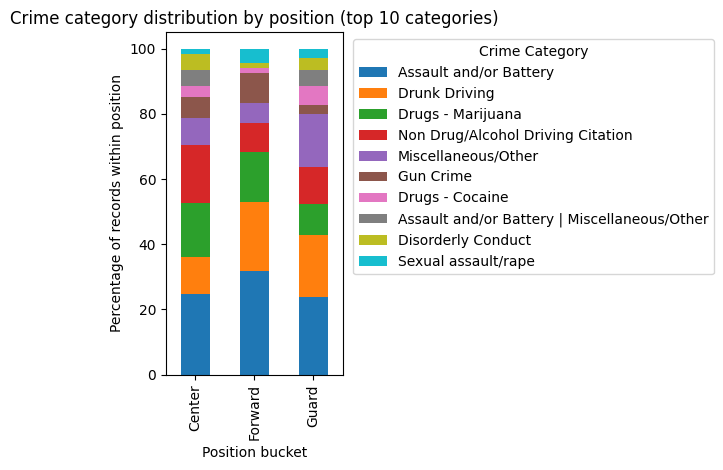

In [101]:


plt.figure(figsize=(10, 5))
pos_cat_props[top10_cats].plot(kind="bar", stacked=True)

plt.title("Crime category distribution by position (top 10 categories)")
plt.ylabel("Percentage of records within position")
plt.xlabel("Position bucket")
plt.legend(title="Crime Category", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Draft capital and crime records

Next, I explore whether arrest records in this dataset are associated with different levels of “draft capital”.

The Kaggle player dataset includes draft information (`DRAFT_ROUND` and `DRAFT_NUMBER`). I group players into four simple bins:

- **Lottery (1–14)**  
- **First round, non-lottery (15–30)**  
- **Second round (31+)**  
- **Undrafted / Unknown** (missing draft info)

This is descriptive: draft position is a proxy for how highly a player was valued entering the league, but it does not imply anything causal about crime behavior.


**Create draft bins**

In [102]:
def draft_bin(draft_number, draft_round):
    """
    Create a simple draft-capital bin.
    Uses DRAFT_NUMBER when available; falls back to DRAFT_ROUND.
    """
    #If both are missing, treat as undrafted/unknown
    if pd.isna(draft_number) and pd.isna(draft_round):
        return "Undrafted/Unknown"

    #Prefer draft number if it exists
    if not pd.isna(draft_number):
        dn = int(draft_number)
        if 1 <= dn <= 14:
            return "Lottery (1–14)"
        elif 15 <= dn <= 30:
            return "1st round (15–30)"
        else:
            return "2nd round (31+)"

    #Fallback: if round is present but number missing
    dr = int(draft_round)
    if dr == 1:
        return "1st round (unknown pick)"
    elif dr == 2:
        return "2nd round (unknown pick)"
    else:
        return "Undrafted/Unknown"

df_merged["Draft Bin"] = df_merged.apply(
    lambda r: draft_bin(r.get("DRAFT_NUMBER"), r.get("DRAFT_ROUND")),
    axis=1
)

df_merged["Draft Bin"].value_counts(dropna=False)


,count
Draft Bin,
Lottery (1–14),131
1st round (15–30),80
2nd round (31+),71
Undrafted/Unknown,34
2nd round (unknown pick),1


**Making sure that one player only counts once (as some have multiple records)**

In [108]:
players_unique = (df_merged.dropna(subset=["PERSON_ID", "Draft Bin"])
                  .drop_duplicates(subset=["PERSON_ID"]))

player_draft_counts = (players_unique.groupby("Draft Bin")
                       .size()
                       .sort_values(ascending=False))

player_draft_counts


,0
Draft Bin,
Lottery (1–14),92
1st round (15–30),57
2nd round (31+),51
Undrafted/Unknown,24
2nd round (unknown pick),1


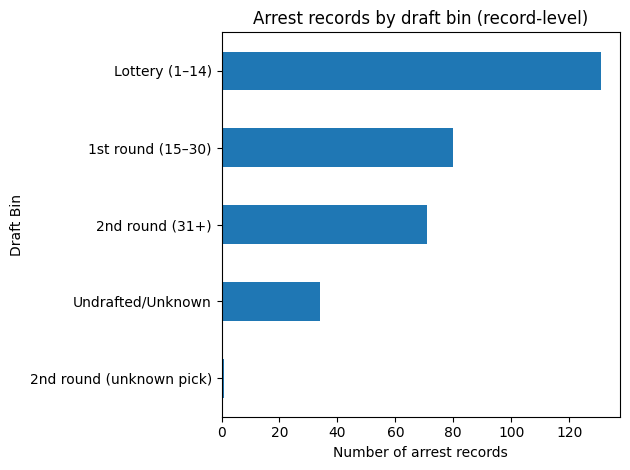

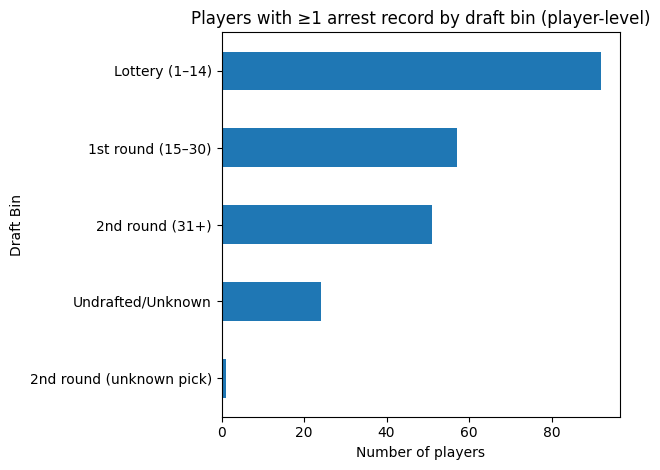

In [109]:
plt.figure()
record_draft_counts.sort_values().plot(kind="barh")
plt.title("Arrest records by draft bin (record-level)")
plt.xlabel("Number of arrest records")
plt.tight_layout()
plt.show()

plt.figure()
player_draft_counts.sort_values().plot(kind="barh")
plt.title("Players with ≥1 arrest record by draft bin (player-level)")
plt.xlabel("Number of players")
plt.tight_layout()
plt.show()


# Interpretation
When grouping players by draft capital, lottery picks (1–14) account for the largest share of the dataset. At the record level, the dataset includes 131 arrest records involving lottery picks, compared to 80 for late first-round picks (15–30), 71 for second-round picks (31+), and 34 for undrafted/unknown players. Importantly, the same ordering holds when counting unique players rather than arrest records (92 lottery picks vs. 57 late first-round vs. 51 second-round vs. 24 undrafted/unknown), suggesting the pattern is not driven only by repeat offenders. This result is descriptive and should be interpreted cautiously: it may reflect differences in media visibility, era coverage, and the underlying distribution of NBA players across draft bins rather than any causal relationship between draft position and criminal behavior.

## Player performance profiles by crime category (PTS/REB/AST)

Next, I explore whether crime categories in the dataset are associated with different *performance profiles* using basic basketball statistics from the augmented Kaggle dataset (PTS, REB, AST).

Note:
- This is descriptive: performance does not “explain” crime.
- The Kaggle stats are not perfectly comparable across eras, and for some players (especially active ones) the dataset may reflect incomplete careers.
- Some arrest records do not match to the Kaggle dataset, so analysis is restricted to rows with available stats.

To reduce bias from repeat offenders (players with multiple arrest records), I report results in two ways:
1) Record-level (each arrest record counts)
2) Player-level (each player counted once)


In [110]:
# Keep only rows with stats available
df_stats = df_merged.dropna(subset=["PTS", "REB", "AST", "Crime Category"]).copy()

# Convert to numeric (just in case)
for col in ["PTS", "REB", "AST"]:
    df_stats[col] = pd.to_numeric(df_stats[col], errors="coerce")

df_stats = df_stats.dropna(subset=["PTS", "REB", "AST"])

print("Rows with PTS/REB/AST available:", len(df_stats))
print("Unique players with stats:", df_stats["PERSON_ID"].nunique())


Rows with PTS/REB/AST available: 308
Unique players with stats: 225


In [111]:
top8 = df_stats["Crime Category"].value_counts().head(8).index
df_stats_top = df_stats[df_stats["Crime Category"].isin(top8)].copy()

df_stats_top["Crime Category"].value_counts()


,count
Crime Category,
Assault and/or Battery,61
Drunk Driving,41
Drugs - Marijuana,30
Non Drug/Alcohol Driving Citation,29
Miscellaneous/Other,26
Gun Crime,13
Drugs - Cocaine,9
Disorderly Conduct,8


In [112]:
record_perf = (df_stats_top
               .groupby("Crime Category")[["PTS", "REB", "AST"]]
               .agg(["count", "mean", "median"])
               .round(2))

record_perf


PTS                 REB               \
                                  count   mean median count  mean median   
Crime Category                                                             
Assault and/or Battery               61   9.61   9.00    61  4.53    4.0   
Disorderly Conduct                    8  11.70  11.50     8  4.72    3.6   
Drugs - Cocaine                       9   9.17   9.10     9  3.00    2.5   
Drugs - Marijuana                    30  11.08  10.75    30  5.14    4.7   
Drunk Driving                        41  10.33   9.80    41  4.52    3.9   
Gun Crime                            13   8.52   7.80    13  4.07    3.7   
Miscellaneous/Other                  26  10.55  11.00    26  3.94    3.2   
Non Drug/Alcohol Driving Citation    29  10.67  10.10    29  4.33    4.1   

                                    AST               
                                  count  mean median  
Crime Category                                        
Assault and/or Battery               61  2.22   1.50  
Disorderly Conduct                    8  2.21   1.75  
Drugs - Cocaine                       9  2.28   1.90  
Drugs - Marijuana                    30  2.23   1.85  
Drunk Driving                        41  2.39   1.60  
Gun Crime                            13  1.51   0.70  
Miscellaneous/Other                  26  2.46   1.65  
Non Drug/Alcohol Driving Citation    29  2.23   1.40

In [113]:
# One row per player (keeps their first occurrence in df_stats_top)
players_top = df_stats_top.drop_duplicates(subset=["PERSON_ID"]).copy()

player_perf = (players_top
               .groupby("Crime Category")[["PTS", "REB", "AST"]]
               .agg(["count", "mean", "median"])
               .round(2))

player_perf


PTS                 REB               \
                                  count   mean median count  mean median   
Crime Category                                                             
Assault and/or Battery               54   9.55   9.00    54  4.40   3.85   
Disorderly Conduct                    7  11.01   6.50     7  4.07   3.30   
Drugs - Cocaine                       9   9.17   9.10     9  3.00   2.50   
Drugs - Marijuana                    24  10.46   9.75    24  5.03   4.75   
Drunk Driving                        36   9.52   8.15    36  4.31   3.85   
Gun Crime                            11   8.16   7.50    11  4.13   3.70   
Miscellaneous/Other                  19  10.19   9.70    19  4.13   3.40   
Non Drug/Alcohol Driving Citation    23  10.37  10.10    23  3.78   4.10   

                                    AST               
                                  count  mean median  
Crime Category                                        
Assault and/or Battery               54  2.21    1.5  
Disorderly Conduct                    7  2.17    1.0  
Drugs - Cocaine                       9  2.28    1.9  
Drugs - Marijuana                    24  2.07    1.8  
Drunk Driving                        36  2.17    1.3  
Gun Crime                            11  1.41    0.7  
Miscellaneous/Other                  19  2.11    1.5  
Non Drug/Alcohol Driving Citation    23  2.26    1.4

/tmp/ipython-input-3131062151.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=cat_order, vert=False)


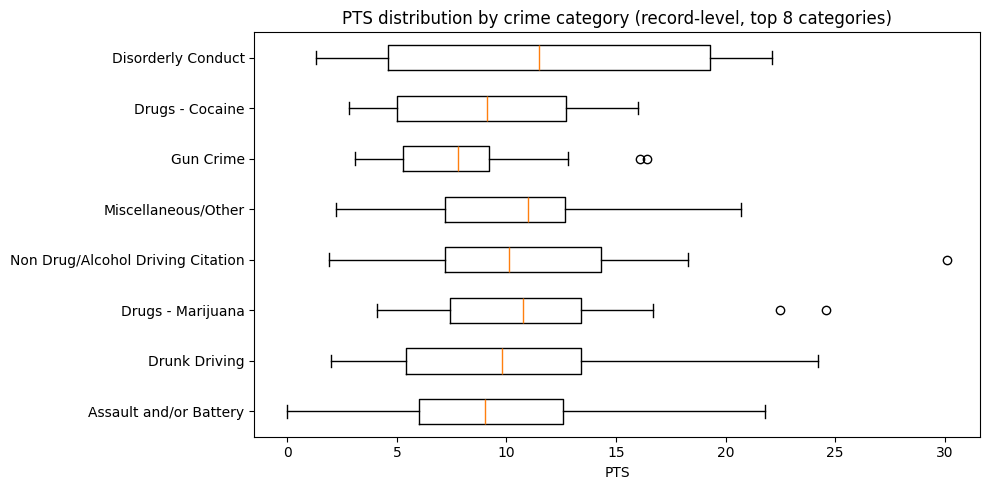

In [114]:
# Prepare data in category order (most frequent first)
cat_order = df_stats_top["Crime Category"].value_counts().index.tolist()

plt.figure(figsize=(10, 5))
data = [df_stats_top[df_stats_top["Crime Category"] == c]["PTS"].values for c in cat_order]

plt.boxplot(data, labels=cat_order, vert=False)
plt.title("PTS distribution by crime category (record-level, top 8 categories)")
plt.xlabel("PTS")
plt.tight_layout()
plt.show()


In [115]:
# Player-level to avoid repeat-offender weighting
players_all = df_stats.drop_duplicates(subset=["PERSON_ID"]).copy()

q75 = players_all["PTS"].quantile(0.75)
players_all["PTS Tier"] = np.where(players_all["PTS"] >= q75, "Top 25% PTS", "Bottom 75% PTS")

tier_table = pd.crosstab(players_all["PTS Tier"], players_all["Crime Category"], normalize="index") * 100
tier_table.round(1)


Crime Category,Assault and/or Battery,Assault and/or Battery | Breaking and Entering / Burglary,Assault and/or Battery | Disorderly Conduct,Assault and/or Battery | Disorderly Conduct | Resisting Arrest,Assault and/or Battery | Gun Crime,Assault and/or Battery | Gun Crime | Miscellaneous/Other,Assault and/or Battery | Miscellaneous/Other,Assault and/or Battery | Non Drug/Alcohol Driving Citation,Assault and/or Battery | Sexual assault/rape,Car theft,...,Gun Crime,Gun Crime | Non Drug/Alcohol Driving Citation,Loitering,Miscellaneous/Other,Miscellaneous/Other | Non Drug/Alcohol Driving Citation,Miscellaneous/Other | Resisting Arrest,Non Drug/Alcohol Driving Citation,Resisting Arrest,Sexual assault/rape,Solicitation of Prostitution
PTS Tier,,,,,,,,,,,,,,,,,,,,,
Bottom 75% PTS,21.6,0.6,0.6,0.6,1.8,0.6,2.4,0.6,0.6,0.6,...,5.4,1.2,1.2,7.2,0.6,0.6,7.8,1.2,1.8,0.0
Top 25% PTS,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.4,...,3.4,0.0,0.0,6.9,1.7,0.0,10.3,0.0,1.7,1.7


#Interpretation
Comparing PTS distributions across the top crime categories shows substantial overlap. Median PTS values are broadly similar across categories (roughly in the 8–12 range), and differences between categories appear small compared to the within-category variation. Several categories include high-PTS outliers (e.g., driving- and drug-related categories), suggesting that highly productive scorers do appear in multiple crime categories, but this does not translate into a clear separation in typical performance levels. A tier-based view (top 25% PTS vs bottom 75%) tells a similar story: the overall category mix remains comparable across tiers, with only modest shifts in a few categories. Overall, the data do not support a strong relationship between scoring performance and crime category within this dataset.

# Future research directions

In hindsight, I realized that I spent time cleaning data allowing for certain analysis without using it in the end. I think there are endless fun possibilities with this dataset, and when scraping the data I hadn't really considered what to do with it yet.

In terms of the analysis I did, these are some ideas for future exploration if I had more time:

**Era-adjusted performance profiles**

Comparing raw PTS across decades is tricky because the league changes over time. A follow-up could normalize performance by era (e.g., z-scores within decade, or relative ranking within the season/era) to see whether any descriptive patterns remain after controlling for historical differences.


**Text analysis beyond LDA (more robust themes)**

Topic modeling with bag-of-words is sensitive to preprocessing. Future work could:

*   compare different topic numbers systematically (5/10/15)
*   use coherence measures (if desired)
*   try embeddings-based clustering (e.g., sentence transformers + k-means) for richer narrative grouping
*   compare the themes obtained from LDA vs embeddings










